In [1]:
import torch
from lightning import LightningModule, LightningDataModule
# import albumentations as A
from torch.utils.data import Dataset, DataLoader
import cv2
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as tf
# from albumentations.pytorch import ToTensorV2
import json
import pandas as pd 
import numpy as np
import pycocotools
import matplotlib.pyplot as plt
from pprint import pprint
from glob import glob
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import imageio
import os
from tqdm.notebook import tqdm_notebook
import sys
sys.path.append('../scripts')
import utils
import lightning as pl

In [ ]:
glob(f'{MAIN_PATH}/Seek Thermal/*')

In [2]:
MAIN_PATH = '../../../dataset/Seek Thermal'
ANNOT_PATH = f'{MAIN_PATH}/rough_annots.json'
# IMAGES_PATHS = sorted(glob(MAIN_PATH+'/Seek Thermal/jpegs/*'))
MASKS_PATHS = sorted(glob(MAIN_PATH+'/masks/*.png'))
IMAGES_PATHS = [f'{MAIN_PATH}/jpegs/'+x.split('\\')[-1].replace('png','jpg') for x in MASKS_PATHS]

with open(ANNOT_PATH, 'r') as f:
    annot = json.load(f)

In [ ]:
class RemoteSensingDataset(Dataset):
    def __init__(self, rasters, targets, width=512, transform=None):
        self.rasters = rasters
        self.targets = targets
        self.width = width
        self.transform = transform

    def __len__(self):
        return len(self.rasters)

    def read_image(self, path):
        return imageio.imread(path)

    def __getitem__(self, idx):
        raster = utils.rotate_to_vertical(self.rasters[idx])
        img_w, img_h = raster.shape[:2]
        target = self.read_image(self.targets[idx])[:img_w,:img_h]

        if self.width:
            raster = cv2.resize(raster,(self.width, self.width), interpolation=cv2.INTER_CUBIC)
            target = cv2.resize(target,(self.width, self.width), interpolation=cv2.INTER_CUBIC)

        temp_target = np.stack([target, target], axis=-1)
        temp_target[...,0] = temp_target[...,0] > 0
        temp_target[...,1] = temp_target[...,1] == 2
        temp_target = temp_target.astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=raster, mask=temp_target)
            raster = transformed["image"]
            target = transformed["mask"]

        return raster.float(), target.float().permute(0,1,2)

class ThermalDataModule(LightningDataModule):
    def __init__(self, rasters, targets, training_split=0.7, batch_size=16, width=512,
                 train_augmentation=None, val_augmentation=None, normalize=False,
                 shuffle=True, deterministic=True, train_indices=None, val_indices=None):
        super().__init__()
        self.rasters = rasters
        self.targets = targets
        self.training_split = training_split
        self.batch_size = batch_size
        self.train_augmentation = train_augmentation
        self.val_augmentation = val_augmentation
        self.normalize = normalize
        self.width = width
        self.shuffle = shuffle
        self.deterministic = deterministic
        self.train_indices = train_indices
        self.val_indices = val_indices

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        num_samples = len(self.rasters)
        indices = np.arange(num_samples)

        if self.train_indices is None and self.val_indices is None:
            split_idx = int(self.training_split * num_samples)
            self.train_indices = indices[:split_idx]
            self.val_indices = indices[split_idx:]


        # Create datasets
        train_dataset = RemoteSensingDataset([self.rasters[i] for i in self.train_indices],
                                             [self.targets[i] for i in self.train_indices],
                                             width=self.width,
                                             transform=self.train_augmentation)
        val_dataset = RemoteSensingDataset([self.rasters[i] for i in self.val_indices],
                                           [self.targets[i] for i in self.val_indices],
                                             width=self.width,
                                           transform=self.val_augmentation)

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=os.cpu_count())

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=os.cpu_count())

In [3]:
NUM_SAMPLES = len(MASKS_PATHS)
indices = np.arange(NUM_SAMPLES)
TRAINING_SPLIT = 0.7
split_idx = int(TRAINING_SPLIT * NUM_SAMPLES)
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

training_image_paths = [IMAGES_PATHS[i] for i in train_indices]
training_masks_paths = [MASKS_PATHS[i] for i in train_indices]

val_image_paths = [IMAGES_PATHS[i] for i in val_indices]
val_masks_paths = [MASKS_PATHS[i] for i in val_indices]

In [ ]:
# simple_img_proc_ds = ThermalDataModule(rasters=IMAGES_PATHS, targets=MASKS_PATHS)
# ml_proc_ds = ThermalDataModule(rasters=IMAGES_PATHS, targets=MASKS_PATHS)

simple_img_proc_ds = RemoteSensingDataset(training_image_paths, training_masks_paths, width=None)

In [9]:
def ROI_extraction(img_paths):
    roi_imgs = []
    for i, img_p in tqdm_notebook(enumerate(img_paths)):
        bboxes, thresh, og_img = utils.mixed_pipeline(img_p=img_p)
        # roi_extracted_img = np.zeros_like(og_img)
        for box in bboxes[1:]:
            roi_extracted_img = np.zeros_like(og_img)
            x,y,w,h,area = box
            if area > 7500:
                # ax.add_patch(patches.Rectangle((x-10,0),w+20,h+y,edgecolor='red', facecolor='none'))
                roi_extracted_img[0:h+y, x-15:x+w+30] = og_img[0:h+y, x-15:x+w+30]

            roi_imgs.append([box, roi_extracted_img])
    return roi_imgs

train_roi_imgs = ROI_extraction(training_image_paths)
val_roi_imgs = ROI_extraction(val_image_paths)

def mask_reading(mask_paths):
    train_masks = [imageio.imread(x) for x in mask_paths]
    cups_masks = [(mask == 1).astype(np.uint8) for mask in train_masks]
    # cv2.connectedComponents()
    comps, labels = cv2.connectedComponents(train_masks[-5])
    ohe_mask = np.eye(comps)[labels]
    # code goes here
    ...
    # train_masks = [(mask == 2).astype(np.uint8) for mask in train_masks]
    return new_train_masks

train_masks = mask_reading(training_masks_paths)
val_masks = mask_reading(val_masks_paths)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

C:\Users\Ayan.Gupta\AppData\Local\Temp\ipykernel_13860\3787196538.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_masks = [imageio.imread(x) for x in mask_paths]


In [27]:
ohe_mask.shape

(1280, 1280, 2)

2


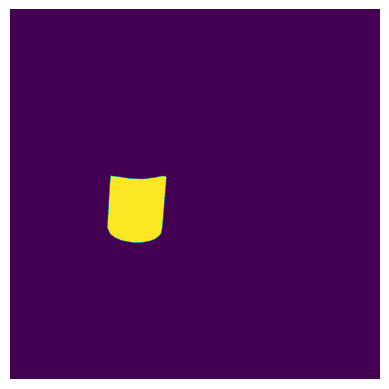

In [24]:
comps, labels = cv2.connectedComponents(train_masks[-5])
ohe_mask = np.eye(comps)[labels]


# print(comps)

# fig, axs = plt.subplots(1, comps-1)
# for i in range(0,comps-1):
#     if comps - 1 == 1:
#         axs.axis('off')
#         axs.imshow(ohe_mask[...,i+1])
#     else:
#         axs[i].axis('off')
#         axs[i].imshow(ohe_mask[...,i+1])

In [10]:
train_roi_imgs.__len__()

# sample_img = roi_extracted_imgs[i][1].copy()
# bbox = roi_extracted_imgs[i][0][0]
# filtered_green = sample_img[...,1] * sample_img[...,0] > 20
# e_img = np.stack([sample_img[...,0],filtered_green, sample_img[...,-1]], -1)
# gray_img = gamma_correction(cv2.cvtColor(e_img, cv2.COLOR_RGB2GRAY), gamma=2.0)
# scaled_gray_img = min_max_scale(gray_img)

84